# SOPHIE vs traditional DE

The goal of this experiment is to determine how often SOPHIE ranks specific genes over generic genes compared to using traditional DE analysis

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import numpy as np
import pandas as pd
import random
import seaborn as sns
from ponyo import utils

np.random.seed(1)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [ ]:
## Need to make sure there is a consistent difference in all experiments in the compendium

## Create simulated data

1. Each perturbation experiment has 8 samples (4 perturbed vs 4 control) with 1000 genes. Create initial expression profiles for 4 samples by drawing from a gaussian with a mean/sd for each gene.
2. Say that there are 100 generic genes selected from the 1000 genes. The generic genes will have the some scalar value added for the “perturbed” samples
3. Each perturbation experiment will have 10 “specific” genes are randomly selected from the remaining 900 non-generic genes. Then the specific genes will have the some scalar value added for the “perturbed” samples
4. Repeat this process 90 times to get 90 experiments

In [2]:
# User params
num_genes = 1000
num_samples = 8
num_generic_genes = 100
num_specific_genes = 10
num_experiments = 90

In [3]:
"""p = random.uniform(0.0, 1.0)
print(p)
np.random.negative_binomial(5, p)"""

'p = random.uniform(0.0, 1.0)\nprint(p)\nnp.random.negative_binomial(5, p)'

In [4]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = "config_sophie_vs_trad.tsv"

params = utils.read_config(config_filename)

In [5]:
# Load config params

# Local directory to store intermediate files
local_dir = params["local_dir"]

# Un-normalized compendium filename
raw_compendium_filename = params["raw_compendium_filename"]

In [6]:
# Pickle files to save
generic_gene_ids_filename = "generic_gene_ids.pickle"

In [7]:
# Setup variables

# Sample ids (4 controls, 4 perturbed)
sample_ids = [
    "0_control",
    "1_control",
    "2_control",
    "3_control",
    "4_perturb",
    "5_perturb",
    "6_perturb",
    "7_perturb",
]

# Make range of numbers into string to use as gene ids
gene_ids = [f"G_{i}" for i in range(num_genes)]

# Randomly select generic gene ids
generic_gene_ids = random.sample(gene_ids, num_generic_genes)
print(generic_gene_ids)

['G_941', 'G_119', 'G_876', 'G_512', 'G_194', 'G_800', 'G_228', 'G_142', 'G_798', 'G_401', 'G_442', 'G_388', 'G_853', 'G_36', 'G_874', 'G_869', 'G_335', 'G_297', 'G_728', 'G_935', 'G_944', 'G_754', 'G_690', 'G_373', 'G_145', 'G_608', 'G_682', 'G_198', 'G_673', 'G_62', 'G_921', 'G_264', 'G_948', 'G_882', 'G_573', 'G_13', 'G_839', 'G_718', 'G_418', 'G_440', 'G_138', 'G_468', 'G_860', 'G_704', 'G_176', 'G_834', 'G_668', 'G_514', 'G_889', 'G_564', 'G_931', 'G_538', 'G_536', 'G_258', 'G_161', 'G_732', 'G_920', 'G_934', 'G_651', 'G_807', 'G_337', 'G_444', 'G_550', 'G_181', 'G_482', 'G_497', 'G_130', 'G_72', 'G_767', 'G_376', 'G_892', 'G_409', 'G_505', 'G_271', 'G_305', 'G_239', 'G_595', 'G_178', 'G_403', 'G_756', 'G_942', 'G_280', 'G_619', 'G_163', 'G_95', 'G_40', 'G_429', 'G_844', 'G_259', 'G_979', 'G_42', 'G_676', 'G_190', 'G_267', 'G_642', 'G_395', 'G_432', 'G_219', 'G_386', 'G_265']


## Supporting functions

In [8]:
# Function to make an individual experiment
def run_make_experiment(
    num_samples,
    num_genes,
    sample_ids,
    all_gene_ids,
    generic_gene_ids,
    specific_gene_ids,
    generic_scaler,
    specific_scaler,
):
    experiment_data = {}
    for gene in range(num_genes):

        # Simulate expression by sampling from a Negative Binomial distribution
        # NB(r,p)
        # r: number of successes until we stop trials
        # p: success rate, the probability that each trial is a success
        # Within an experiment, each trial can have 2 outcomes = success or failure
        # Within a trial, the probability of success is p
        # NB()
        # Randomly select a different success probability for each gene so that
        # each gene has a different rate at which its expressed
        p = random.uniform(0.0, 1.0)
        gene_profile = np.random.negative_binomial(5, p, num_samples)

        # Create dictionary to define dataframe
        experiment_data[f"G_{gene}"] = gene_profile

    # Create experiment dataframe
    experiment_df = pd.DataFrame(experiment_data)

    # Set index
    experiment_df.index = sample_ids

    # Perturb generic genes by scaler
    # Randomly select a scaler
    # Only add scaler to perturbed samples
    experiment_df.loc[
        experiment_df.index.str.contains("perturb"), generic_gene_ids
    ] += generic_scaler

    # Perturb specific genes by a different scaler
    experiment_df.loc[
        experiment_df.index.str.contains("perturb"), specific_gene_ids
    ] += specific_scaler

    return experiment_df

In [9]:
# Make multiple experiments
def make_experiments(
    num_experiments,
    num_samples,
    num_genes,
    sample_ids,
    all_gene_ids,
    generic_gene_ids,
    num_specific_genes,
):

    expression_df = pd.DataFrame()
    specific_gene_id_lst = []

    for i in range(num_experiments):

        # Randomly select specific genes from the pool of (900)remaining genes
        # Select without replacement
        remaining_gene_ids = list(set(all_gene_ids).difference(generic_gene_ids))
        specific_gene_ids = random.sample(remaining_gene_ids, num_specific_genes)

        # Save specific gene ids for reference later
        specific_gene_id_lst.append(specific_gene_ids)

        # Randomly select scaler for generic and specific genes from the same distribution
        p = random.uniform(0.0, 0.7)
        generic_scaler = np.random.negative_binomial(20, p)
        specific_scaler = np.random.negative_binomial(20, p)

        experiment_df = run_make_experiment(
            num_samples,
            num_genes,
            sample_ids,
            all_gene_ids,
            generic_gene_ids,
            specific_gene_ids,
            generic_scaler,
            specific_scaler,
        )

        # Concatenate experiments
        expression_df = pd.concat([expression_df, experiment_df])

    # Try to reset index to see if this makes a difference
    # NOTE: VAE don't train when sample indices are identical, not sure why
    if num_experiments > 1:
        expression_df = expression_df.reset_index(drop=True)

    return expression_df, specific_gene_id_lst

## Make a template experiment

In [10]:
for i in range(10):
    template_experiment, template_specific_gene_ids = make_experiments(
        1,
        num_samples,
        num_genes,
        sample_ids,
        gene_ids,
        generic_gene_ids,
        num_specific_genes,
    )

    # Save template experiment
    raw_template_filename = f"/home/alexandra/Documents/Data/Generic_expression_patterns/reviewer_experiment/raw_template_{i}.tsv"
    template_experiment.to_csv(raw_template_filename, sep="\t")

    # Pickle specific gene ids
    template_specific_gene_ids_filename = f"/home/alexandra/Documents/Data/Generic_expression_patterns/reviewer_experiment/template_specific_gene_ids_{i}.pickle"
    with open(template_specific_gene_ids_filename, "wb") as pkl_fh:
        pickle.dump(template_specific_gene_ids[0], pkl_fh, protocol=3)

In [11]:
print(template_experiment.shape)
template_experiment.head(8)

(8, 1000)


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,1,11,0,2,9,0,5,6,0,77,...,36,1,8,1,6,1,1,11,1,5
1_control,0,12,0,2,5,0,3,12,0,54,...,51,0,18,2,8,2,0,9,0,4
2_control,2,4,0,1,5,0,0,3,0,72,...,63,0,18,3,12,4,0,11,0,1
3_control,1,11,0,5,3,0,9,5,2,52,...,83,1,9,1,4,3,2,0,1,3
4_perturb,1,18,0,0,3,0,3,16,0,46,...,70,0,8,3,5,1,0,4,0,4
5_perturb,1,8,1,2,7,0,5,0,0,93,...,104,1,18,0,7,1,0,2,0,3
6_perturb,0,16,0,1,9,0,3,5,0,43,...,56,1,6,1,9,0,0,5,0,0
7_perturb,2,13,0,3,2,0,6,14,1,51,...,30,2,28,0,6,2,0,8,0,2


In [12]:
template_specific_gene_ids[0]

['G_30',
 'G_966',
 'G_695',
 'G_480',
 'G_455',
 'G_504',
 'G_18',
 'G_503',
 'G_537',
 'G_611']

## Check template experiment

We want to verify that we have a good differential expression signal - i.e. control and perturb samples separate based on specific and common genes

In [13]:
i = 0

In [14]:
template_filename = f"/home/alexandra/Documents/Data/Generic_expression_patterns/reviewer_experiment/raw_template_{i}.tsv"

In [15]:
template_specific_gene_ids_filename = f"/home/alexandra/Documents/Data/Generic_expression_patterns/reviewer_experiment/template_specific_gene_ids_{i}.pickle"

In [16]:
template_experiment = pd.read_csv(template_filename, sep="\t", index_col=0, header=0)

In [17]:
with open(template_specific_gene_ids_filename, "rb") as specific_fh:
    specific_gene_ids = pickle.load(specific_fh)

In [18]:
# Get NA genes
all_gene_ids = template_experiment.columns
all_gene_ids_tmp = all_gene_ids.difference(template_specific_gene_ids[0])
na_gene_ids = all_gene_ids_tmp.difference(generic_gene_ids)

In [19]:
# Template data subsets
template_specific_df = template_experiment[template_specific_gene_ids[0]]
template_common_df = template_experiment[generic_gene_ids]
template_na_df = template_experiment[na_gene_ids]

In [20]:
print(template_specific_df.shape)
template_specific_df

(8, 10)


,G_30,G_966,G_695,G_480,G_455,G_504,G_18,G_503,G_537,G_611
0_control,7,15,5,39,13,0,3,0,78,3
1_control,1,16,3,71,10,0,3,0,87,0
2_control,2,12,3,117,15,0,3,2,26,3
3_control,0,8,12,55,17,0,4,0,23,1
4_perturb,3,12,8,54,13,0,2,4,76,2
5_perturb,3,23,3,49,7,0,3,1,9,2
6_perturb,4,25,6,71,6,0,5,1,47,0
7_perturb,5,5,0,96,7,1,2,0,7,1


In [21]:
print(template_common_df.shape)
template_common_df

(8, 100)


,G_941,G_119,G_876,G_512,G_194,G_800,G_228,G_142,G_798,G_401,...,G_42,G_676,G_190,G_267,G_642,G_395,G_432,G_219,G_386,G_265
0_control,0,1,7,30,0,1,4,139,28,3,...,7,2,35,26,11,9,11,0,3,9
1_control,0,8,1,35,0,0,5,382,11,2,...,4,1,33,20,11,25,17,0,1,1
2_control,1,3,8,31,0,1,1,217,17,1,...,11,1,41,19,10,9,22,0,1,2
3_control,0,7,2,18,1,4,0,230,17,0,...,2,0,16,20,16,12,28,0,1,3
4_perturb,12,15,15,38,12,17,12,151,30,15,...,18,13,24,36,17,39,24,13,12,17
5_perturb,13,19,15,26,12,18,16,184,13,13,...,20,14,44,61,14,21,24,12,12,12
6_perturb,13,17,15,19,13,15,13,205,34,12,...,23,15,31,31,19,33,25,12,13,12
7_perturb,12,21,19,55,12,21,15,202,23,12,...,17,13,44,18,22,30,24,12,13,13


In [22]:
print(template_na_df.shape)
template_na_df

(8, 890)


,G_0,G_1,G_10,G_100,G_101,G_102,G_103,G_104,G_105,G_106,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0_control,4,7,1,1,4,0,1,5,7,5,...,21,2,6,0,5,1,3,2,1,2
1_control,6,10,1,0,0,0,2,1,14,3,...,14,4,3,1,11,1,6,3,0,2
2_control,5,7,1,0,0,0,0,3,6,2,...,35,2,5,2,4,0,6,8,1,2
3_control,4,6,2,0,3,0,1,5,9,1,...,20,1,1,2,4,0,4,2,1,0
4_perturb,4,2,2,0,6,0,1,1,8,1,...,42,2,3,1,17,9,1,8,1,2
5_perturb,3,3,0,2,7,0,0,0,8,0,...,31,0,3,0,16,8,6,6,2,0
6_perturb,11,5,2,0,5,0,0,1,9,4,...,9,1,13,1,1,8,9,9,1,0
7_perturb,8,6,2,0,8,1,0,0,9,3,...,10,0,6,2,17,8,1,10,1,2


Text(0.5, 0.98, 'Template experiment specific genes')

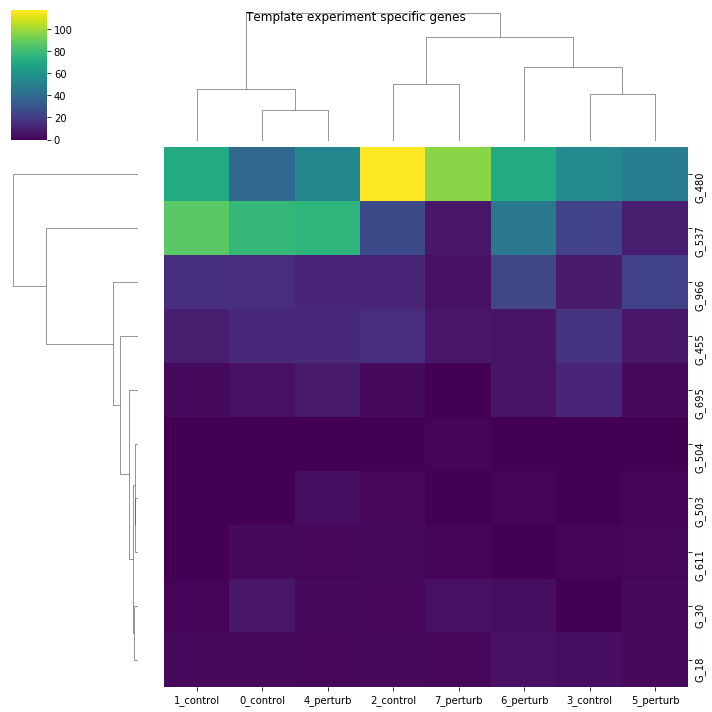

In [23]:
f = sns.clustermap(template_specific_df.T, cmap="viridis")
f.fig.suptitle("Template experiment specific genes")

Text(0.5, 0.98, 'Template experiment common genes')

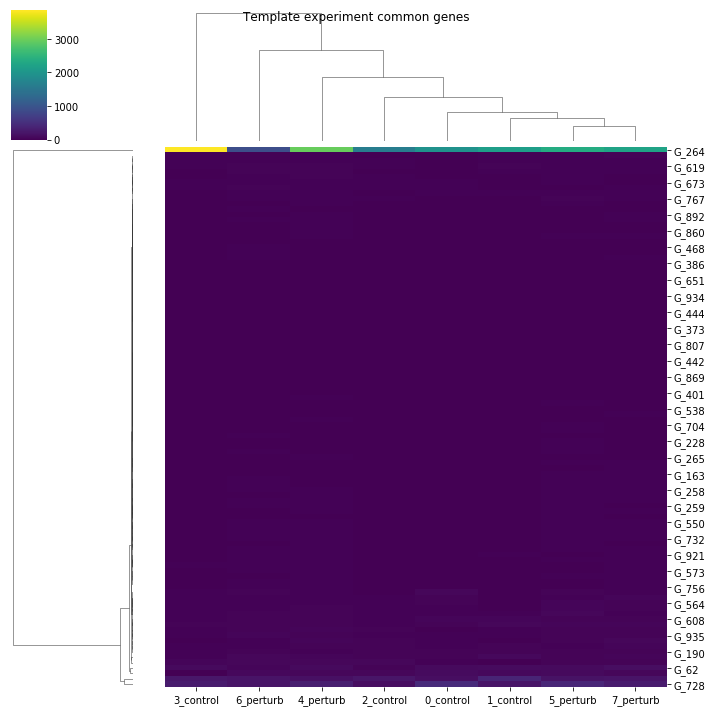

In [24]:
f = sns.clustermap(template_common_df.T, cmap="viridis")
f.fig.suptitle("Template experiment common genes")

Text(0.5, 0.98, 'Template experiment NA genes')

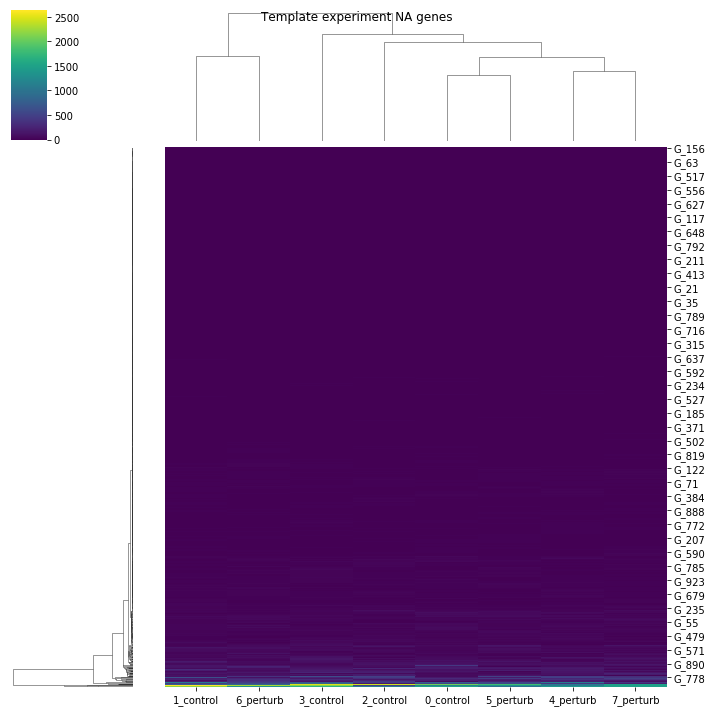

In [25]:
f = sns.clustermap(template_na_df.T, cmap="viridis")
f.fig.suptitle("Template experiment NA genes")

## Make compendium

In [26]:
compendium, compendium_specific_ids = make_experiments(
    num_experiments,
    num_samples,
    num_genes,
    sample_ids,
    gene_ids,
    generic_gene_ids,
    num_specific_genes,
)

In [27]:
print(compendium.shape)
compendium.head()

(720, 1000)


,G_0,G_1,G_2,G_3,G_4,G_5,G_6,G_7,G_8,G_9,...,G_990,G_991,G_992,G_993,G_994,G_995,G_996,G_997,G_998,G_999
0,3,9,2,2,2,3,12,11,21,1,...,0,1,27,4,1,19,8,0,4,307
1,3,2,1,7,6,3,12,21,31,1,...,4,0,50,2,6,3,5,1,6,700
2,2,3,0,3,2,2,5,12,20,0,...,0,1,20,0,3,2,8,2,3,286
3,3,6,3,7,10,3,2,12,37,0,...,4,3,23,2,3,6,8,1,2,1500
4,2,3,4,4,1,1,6,6,13,0,...,4,0,36,1,2,0,8,2,1,778


In [28]:
compendium_specific_ids

[['G_188',
  'G_243',
  'G_128',
  'G_813',
  'G_969',
  'G_615',
  'G_744',
  'G_179',
  'G_147',
  'G_473'],
 ['G_930',
  'G_990',
  'G_590',
  'G_749',
  'G_354',
  'G_222',
  'G_955',
  'G_453',
  'G_830',
  'G_480'],
 ['G_792',
  'G_107',
  'G_353',
  'G_736',
  'G_24',
  'G_325',
  'G_737',
  'G_262',
  'G_369',
  'G_972'],
 ['G_851',
  'G_485',
  'G_976',
  'G_344',
  'G_995',
  'G_526',
  'G_153',
  'G_925',
  'G_41',
  'G_260'],
 ['G_945',
  'G_35',
  'G_80',
  'G_241',
  'G_237',
  'G_742',
  'G_746',
  'G_221',
  'G_699',
  'G_123'],
 ['G_255',
  'G_870',
  'G_607',
  'G_517',
  'G_10',
  'G_531',
  'G_16',
  'G_67',
  'G_430',
  'G_238'],
 ['G_37',
  'G_127',
  'G_262',
  'G_775',
  'G_266',
  'G_94',
  'G_981',
  'G_454',
  'G_177',
  'G_211'],
 ['G_751',
  'G_54',
  'G_124',
  'G_473',
  'G_739',
  'G_519',
  'G_614',
  'G_605',
  'G_560',
  'G_171'],
 ['G_583',
  'G_515',
  'G_797',
  'G_568',
  'G_462',
  'G_890',
  'G_585',
  'G_721',
  'G_1',
  'G_12'],
 ['G_252',
  '

In [29]:
# Save
compendium.to_csv(raw_compendium_filename, sep="\t")

# Save generic genes
# Pickle `scaler` as `scaler_filename` on disk
with open(generic_gene_ids_filename, "wb") as pkl_fh:
    pickle.dump(generic_gene_ids, pkl_fh, protocol=3)